# Overview

1. Project Instructions & Prerequisites
2. Learning Objectives
3. Data Preparation
4. Create Categorical Features with TF Feature Columns
5. Create Continuous/Numerical Features with TF Feature Columns
6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers
7. Evaluating Potential Model Biases with Aequitas Toolkit


#  1. Project Instructions & Prerequisites

## Project Instructions

**Context**: EHR data is becoming a key source of real-world evidence (RWE) for the pharmaceutical industry and regulators to [make decisions on clinical trials](https://www.fda.gov/news-events/speeches-fda-officials/breaking-down-barriers-between-clinical-trials-and-clinical-care-incorporating-real-world-evidence). You are a data scientist for an exciting unicorn healthcare startup that has created a groundbreaking diabetes drug that is ready for clinical trial testing. It is a very unique and sensitive drug that requires administering the drug over at least 5-7 days of time in the hospital with frequent monitoring/testing and patient medication adherence training with a mobile application. You have been provided a patient dataset from a client partner and are tasked with building a predictive model that can identify which type of patients the company should focus their efforts testing this drug on. Target patients are people that are likely to be in the hospital for this duration of time and will not incur significant additional costs for administering this drug to the patient and monitoring.  

In order to achieve your goal you must build a regression model that can predict the estimated hospitalization time for a patient and use this to select/filter patients for your study.


**Expected Hospitalization Time Regression Model:** Utilizing a synthetic dataset(denormalized at the line level augmentation) built off of the UCI Diabetes readmission dataset, students will build a regression model that predicts the expected days of hospitalization time and then convert this to a binary prediction of whether to include or exclude that patient from the clinical trial.

This project will demonstrate the importance of building the right data representation at the encounter level, with appropriate filtering and preprocessing/feature engineering of key medical code sets. This project will also require students to analyze and interpret their model for biases across key demographic groups. 

Please see the project rubric online for more details on the areas your project will be evaluated.

### Dataset

Due to healthcare PHI regulations (HIPAA, HITECH), there are limited number of publicly available datasets and some datasets require training and approval. So, for the purpose of this exercise, we are using a dataset from UC Irvine(https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008) that has been modified for this course. Please note that it is limited in its representation of some key features such as diagnosis codes which are usually an unordered list in 835s/837s (the HL7 standard interchange formats used for claims and remits).

**Data Schema**
The dataset reference information can be https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/
. There are two CSVs that provide more details on the fields and some of the mapped values.

## Project Submission 

When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "student_project_submission.ipynb" and save another copy as an HTML file by clicking "File" -> "Download as.."->"html". Include the "utils.py" and "student_utils.py" files in your submission. The student_utils.py should be where you put most of your code that you write and the summary and text explanations should be written inline in the notebook. Once you download these files, compress them into one zip file for submission.

## Prerequisites 

- Intermediate level knowledge of Python
- Basic knowledge of probability and statistics
- Basic knowledge of machine learning concepts
- Installation of Tensorflow 2.0 and other dependencies(conda environment.yml or virtualenv requirements.txt file provided)

## Environment Setup

For step by step instructions on creating your environment, please go to https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/README.md.

# 2.  Learning Objectives

By the end of the project, you will be able to 
   - Use the Tensorflow Dataset API to scalably extract, transform, and load datasets and build datasets aggregated at the line, encounter, and patient data levels(longitudinal)
   - Analyze EHR datasets to check for common issues (data leakage, statistical properties, missing values, high cardinality) by performing exploratory data analysis.
   - Create categorical features from Key Industry Code Sets (ICD, CPT, NDC) and reduce dimensionality for high cardinality features by using embeddings 
   - Create derived features(bucketing, cross-features, embeddings) utilizing Tensorflow feature columns on both continuous and categorical input features
   - SWBAT use the Tensorflow Probability library to train a model that provides uncertainty range predictions that allow for risk adjustment/prioritization and triaging of predictions
   - Analyze and determine biases for a model for key demographic groups by evaluating performance metrics across groups by using the Aequitas framework 


# 3. Data Preparation

In [1]:
# from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import aequitas as ae
# Put all of the helper functions in utils
from utils import build_vocab_files, show_group_stats_viz, aggregate_dataset, preprocess_df, df_to_dataset, posterior_mean_field, prior_trainable
pd.set_option('display.max_columns', 500)
# this allows you to make changes and save in student_utils.py and the file is reloaded every time you run a code block
%load_ext autoreload
%autoreload

In [2]:
#OPEN ISSUE ON MAC OSX for TF model training
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Dataset Loading and Schema Review

Load the dataset and view a sample of the dataset along with reviewing the schema reference files to gain a deeper understanding of the dataset. The dataset is located at the following path https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/starter_code/data/final_project_dataset.csv. Also, review the information found in the data schema https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/

In [3]:
dataset_path = "./data/final_project_dataset.csv"
df = pd.read_csv(dataset_path)

## Determine Level of Dataset (Line or Encounter)

**Question 1**: Based off of analysis of the data, what level is this dataset? Is it at the line or encounter level? Are there any key fields besides the encounter_id and patient_nbr fields that we should use to aggregate on? Knowing this information will help inform us what level of aggregation is necessary for future steps and is a step that is often overlooked. 

In [4]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO


In [5]:
len(df["encounter_id"].unique())

101766

In [6]:
len(df)

143424

In [7]:
len(df["patient_nbr"].unique())

71518

In [8]:
# One more test: To be sure that this is at line level, let's check that there is at least 1 encounter repeated in this dataset
df[['encounter_id','patient_nbr']].groupby('encounter_id').agg(['count'])

,patient_nbr
,count
encounter_id,
12522,2
15738,2
16680,2
28236,1
35754,1
...,...
443847548,2
443847782,1


As the length of the dataset is greater than the unique encounter ids and encounter_ids are repeated,
it is clear that this is a line level dataset

## Analyze Dataset

**Question 2**: Utilizing the library of your choice (recommend Pandas and Seaborn or matplotlib though), perform exploratory data analysis on the dataset. In particular be sure to address the following questions:  
    - a. Field(s) with high amount of missing/zero values
    - b. Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?
    - c. Which field(s) have high cardinality and why (HINT: ndc_code is one feature)
    - d. Please describe the demographic distributions in the dataset for the age and gender fields.
    


In [9]:
null_df = pd.DataFrame({'columns': df.columns,
                        'percent_null': df.isnull().sum() * 100 / len(df), 
                        'percent_zero': df.isin([0]).sum() * 100 / len(df)
                        } )
null_df

,columns,percent_null,percent_zero
encounter_id,encounter_id,0.00000,0.000000
patient_nbr,patient_nbr,0.00000,0.000000
race,race,0.00000,0.000000
gender,gender,0.00000,0.000000
age,age,0.00000,0.000000
weight,weight,0.00000,0.000000
admission_type_id,admission_type_id,0.00000,0.000000
discharge_disposition_id,discharge_disposition_id,0.00000,0.000000
admission_source_id,admission_source_id,0.00000,0.000000
time_in_hospital,time_in_hospital,0.00000,0.000000


a. Only ndc_code has null values. This is to be expected, as it is not necessary for a drug code to apply to every patient interaction within an encounter. The columns number_outpatient, number_inpatient, number_emergency, num_procedures have high percentage of zero values. Again, this is to be expected. Not all visits will be inpatient, outpatient, emergency or involve procedures.

**OPTIONAL**: Use the Tensorflow Data Validation and Analysis library to complete. 
- The Tensorflow Data Validation and Analysis library(https://www.tensorflow.org/tfx/data_validation/get_started) is a useful tool for analyzing and summarizing dataset statistics. It is especially useful because it can scale to large datasets that do not fit into memory. 
- Note that there are some bugs that are still being resolved with Chrome v80 and we have moved away from using this for the project. 

**Student Response**: Following error loading the tensor_data_validation package: Error importing tfx_bsl_extension.arrow.array_util. Some tfx_bsl functionalities are not available

In [12]:
######NOTE: The visualization will only display in Chrome browser. ########

#import tensorflow_data_validation as tfdv
#full_data_stats = tfdv.generate_statistics_from_csv(data_location='./data/final_project_dataset.csv') 
#tfdv.visualize_statistics(full_data_stats)

In [13]:
# Histograms
df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
primary_diagnosis_code      object
other_diagnosis_codes       object
number_outpatient            int64
number_inpatient             int64
number_emergency             int64
num_lab_procedures           int64
number_diagnoses             int64
num_medications              int64
num_procedures               int64
ndc_code                    object
max_glu_serum               object
A1Cresult                   object
change                      object
readmitted                  object
dtype: object

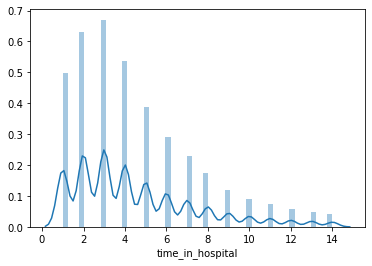

In [14]:
sns.distplot(df['time_in_hospital'])

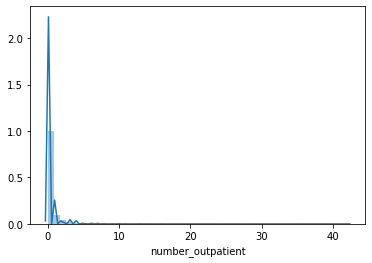

In [15]:
sns.distplot(df['number_outpatient'])

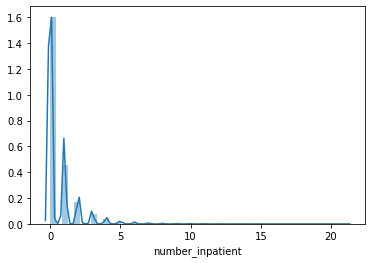

In [16]:
sns.distplot(df['number_inpatient'])

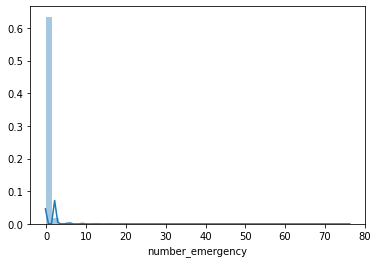

In [17]:
sns.distplot(df['number_emergency'])

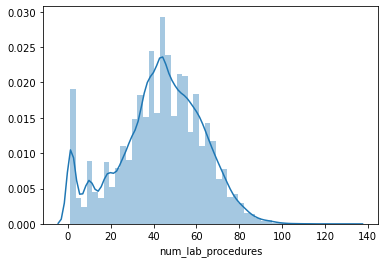

In [18]:
sns.distplot(df['num_lab_procedures'])

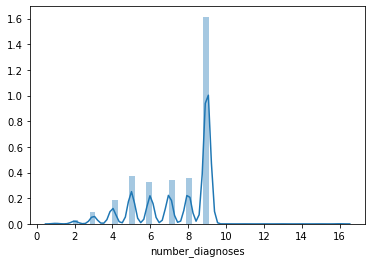

In [19]:
sns.distplot(df['number_diagnoses'])

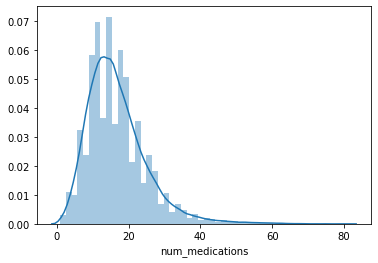

In [20]:
sns.distplot(df['num_medications'])

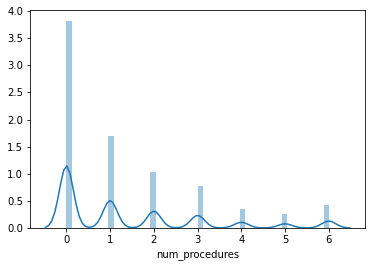

In [21]:
sns.distplot(df['num_procedures'])

b. Looking at the histograms above, num_lab_procedures and num_medications are the only ones that have more or less a Gaussian distribution.

Quick check for outliers. From the histograms above, let's check outliers for number_diagnoses, num_procedures, num_medications

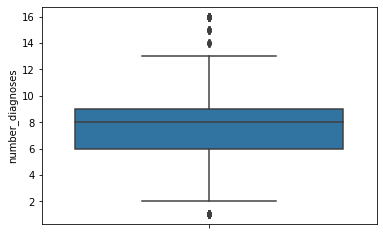

In [22]:
sns.boxplot(y = df['number_diagnoses'])

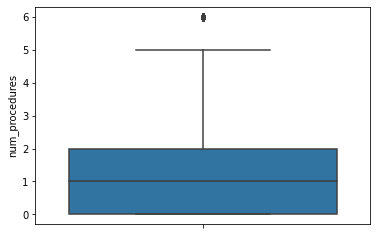

In [23]:
sns.boxplot(y = df['num_procedures'])

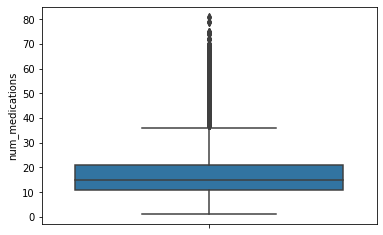

In [24]:
sns.boxplot(y = df['num_medications'])

We see a large number of outliers in the num_medications field.

In [25]:
# High cardinality fields
# The dataset schema in project_data_schema.csv gives us the cardinality of categorical data, but we double check it here
categorical_columns = ['race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty', 'primary_diagnosis_code', 
                       'other_diagnosis_codes', 'ndc_code', 'max_glu_serum', 'A1Cresult', 'change', 'readmitted', 
                       'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'num_procedures', 'num_medications']
print('Cardinality:\n')
for i in categorical_columns:
    print('{}: {}'.format(i, df[i].nunique()))


Cardinality:

race: 6
gender: 3
age: 10
weight: 10
payer_code: 18
medical_specialty: 73
primary_diagnosis_code: 717
other_diagnosis_codes: 19374
ndc_code: 251
max_glu_serum: 4
A1Cresult: 4
change: 2
readmitted: 3
admission_type_id: 8
discharge_disposition_id: 26
admission_source_id: 17
num_procedures: 7
num_medications: 75


c. Columns with high cardinality are: primary_diagnosis_code, other_diagnosis_codes, ndc_code

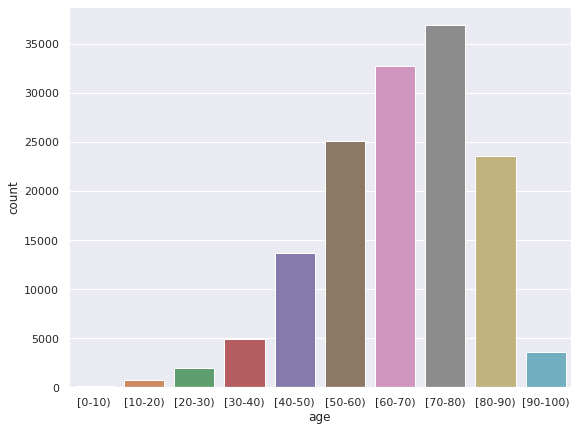

In [26]:
# Age and gender distribution
sns.set(rc={'figure.figsize':(9,7)})
sns.countplot(df['age'])

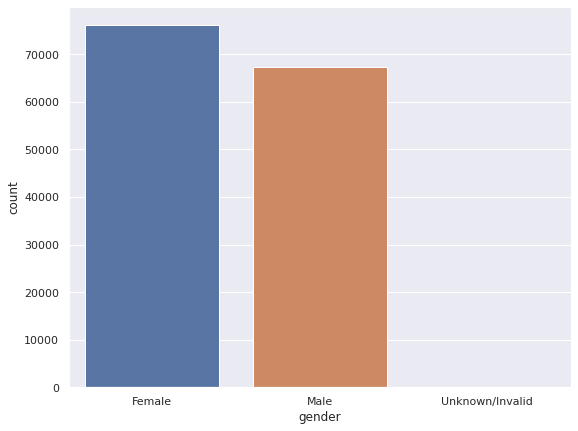

In [27]:
sns.countplot(df['gender'])

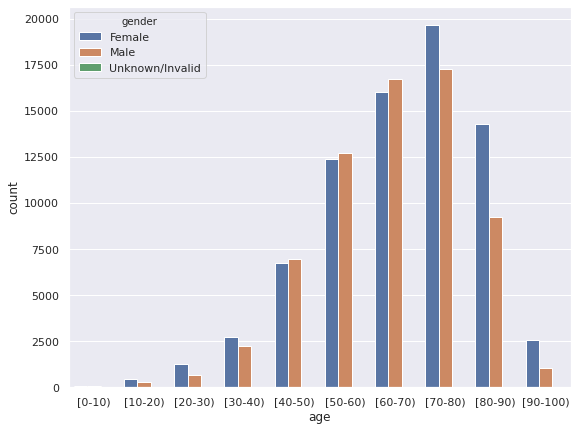

In [28]:
# Age and gender together
sns.countplot(x="age", hue="gender", data=df)

d. Individuals in the age range 0-40 and 90+ are under-represented in this dataset. 
There are marginally more female than male patients, and negligible number of unknown or invalid gender.
For ages 20-30 and above 70 years, there are more considerably more female than male.

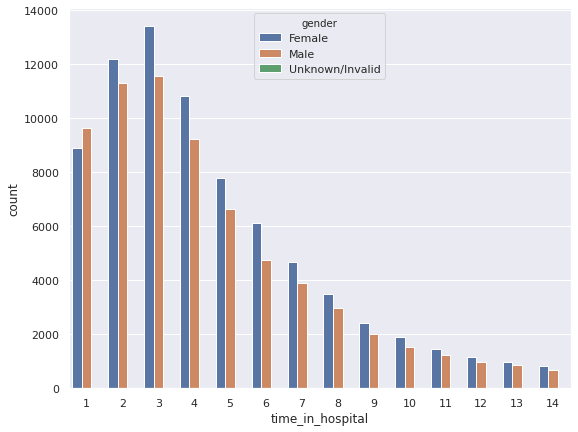

In [29]:
sns.countplot(x="time_in_hospital", hue="gender", data=df)

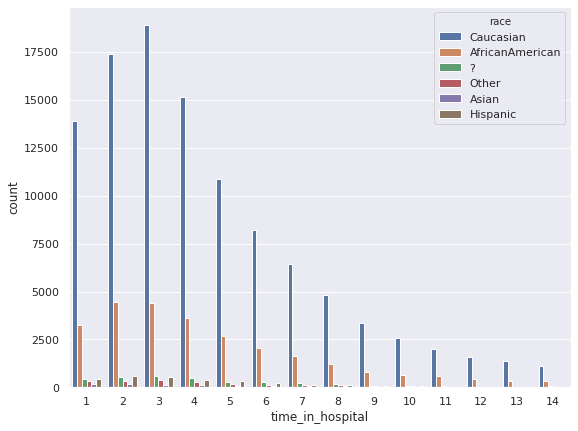

In [30]:
sns.countplot(x="time_in_hospital", hue="race", data=df)

## Reduce Dimensionality of the NDC Code Feature

**Question 3**: NDC codes are a common format to represent the wide variety of drugs that are prescribed for patient care in the United States. The challenge is that there are many codes that map to the same or similar drug. You are provided with the ndc drug lookup file https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/ndc_lookup_table.csv derived from the National Drug Codes List site(https://ndclist.com/). Please use this file to come up with a way to reduce the dimensionality of this field and create a new field in the dataset called "generic_drug_name" in the output dataframe. 

In [31]:
#NDC code lookup file
ndc_code_path = "./medication_lookup_tables/final_ndc_lookup_table"
ndc_code_df = pd.read_csv(ndc_code_path)

In [32]:
ndc_code_df.head(20)

,NDC_Code,Proprietary Name,Non-proprietary Name,Dosage Form,Route Name,Company Name,Product Type
0,0087-6060,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
1,0087-6063,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
2,0087-6064,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
3,0087-6070,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
4,0087-6071,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
5,0093-7212,Metformin Hydrochloride,Metformin Hydrochloride,"Tablet, Extended Release",Oral,"Teva Pharmaceuticals Usa, Inc.",Human Prescription Drug
6,0093-7267,Metformin Hydrochloride,Metformin Hydrochloride,"Tablet, Extended Release",Oral,"Teva Pharmaceuticals Usa, Inc.",Human Prescription Drug
7,0093-7455,Glipizide And Metformin Hydrochloride,Glipizide And Metformin Hydrochloride,"Tablet, Film Coated",Oral,"Teva Pharmaceuticals Usa, Inc.",Human Prescription Drug
8,0093-7456,Glipizide And Metformin Hydrochloride,Glipizide And Metformin Hydrochloride,"Tablet, Film Coated",Oral,"Teva Pharmaceuticals Usa, Inc.",Human Prescription Drug
9,0093-7457,Glipizide And Metformin Hydrochloride,Glipizide And Metformin Hydrochloride,"Tablet, Film Coated",Oral,"Teva Pharmaceuticals Usa, Inc.",Human Prescription Drug


In [33]:
# Identify the smallest character set to match to non-proprietary name in drug code list. 
# Then check the drug code list to ensure the same non-proprietary name applies to this set.
# Turns out we need 8 characters to ensure the same non-proprietary name. The set of 7 fails for 42291-6
set(df['ndc_code'].str[0:7])

{'0009-03',
 '0009-34',
 '0009-50',
 '0039-02',
 '0049-01',
 '0049-41',
 '0054-01',
 '0078-03',
 '0087-60',
 '0093-72',
 '0093-74',
 '0093-80',
 '0093-83',
 '0093-93',
 '0093-94',
 '0115-17',
 '0143-99',
 '0169-00',
 '0173-08',
 '0179-02',
 '0185-44',
 '0228-27',
 '0378-00',
 '0378-02',
 '0378-03',
 '0378-05',
 '0378-11',
 '0378-40',
 '0378-71',
 '0574-02',
 '0591-04',
 '0591-24',
 '0591-27',
 '0591-33',
 '0615-79',
 '0615-80',
 '0615-82',
 '0781-54',
 '0781-55',
 '0781-56',
 '0904-63',
 '0904-66',
 '10631-0',
 '10631-2',
 '12634-7',
 '16714-9',
 '16729-0',
 '23155-1',
 '23155-2',
 '24658-7',
 '24724-0',
 '25000-1',
 '29033-0',
 '33261-1',
 '33261-3',
 '33261-8',
 '33261-9',
 '33342-1',
 '33342-2',
 '35208-0',
 '35356-8',
 '42291-1',
 '42291-3',
 '42291-5',
 '42291-6',
 '42385-9',
 '42571-1',
 '42708-0',
 '43063-1',
 '43063-5',
 '43063-6',
 '43063-9',
 '43547-3',
 '47918-8',
 '47918-9',
 '49884-9',
 '50090-0',
 '50090-1',
 '50090-2',
 '50090-3',
 '50268-3',
 '50436-7',
 '51079-4',
 '51

It's easier then to simply look up the drug code in the main df, in the NDC code list. We implement this in student_utils

In [34]:
from student_utils import reduce_dimension_ndc

In [35]:
reduce_dim_df = reduce_dimension_ndc(df, ndc_code_df)

In [36]:
reduce_dim_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,NDC_Code,generic_drug_name
0,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30,68071-1701,Human Insulin
1,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO,68071-1701,Human Insulin
2,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,68071-1701,None,None,Ch,NO,68071-1701,Human Insulin
3,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,434,198|486,0,0,0,33,8,18,3,68071-1701,None,None,Ch,NO,68071-1701,Human Insulin
4,28236,89869032,AfricanAmerican,Female,[40-50),?,1,1,7,9,?,?,250.7,403|996,0,0,0,47,9,17,2,68071-1701,None,None,No,>30,68071-1701,Human Insulin


In [37]:
# Number of unique values should be less for the new output field
assert df['ndc_code'].nunique() > reduce_dim_df['generic_drug_name'].nunique()

## Select First Encounter for each Patient 

**Question 4**: In order to simplify the aggregation of data for the model, we will only select the first encounter for each patient in the dataset. This is to reduce the risk of data leakage of future patient encounters and to reduce complexity of the data transformation and modeling steps. We will assume that sorting in numerical order on the encounter_id provides the time horizon for determining which encounters come before and after another.

In [38]:
from student_utils import select_first_encounter
first_encounter_df = select_first_encounter(reduce_dim_df)

In [39]:
# unique patients in transformed dataset
unique_patients = first_encounter_df['patient_nbr'].nunique()
print("Number of unique patients:{}".format(unique_patients))

# unique encounters in transformed dataset
unique_encounters = first_encounter_df['encounter_id'].nunique()
print("Number of unique encounters:{}".format(unique_encounters))

original_unique_patient_number = reduce_dim_df['patient_nbr'].nunique()
# number of unique patients should be equal to the number of unique encounters and patients in the final dataset
assert original_unique_patient_number == unique_patients
assert original_unique_patient_number == unique_encounters
print("Tests passed!!")

Number of unique patients:56133
Number of unique encounters:56133
Tests passed!!


In [40]:
first_encounter_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,NDC_Code,generic_drug_name
22979,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,398,427|38,0,0,0,68,8,28,2,0049-4110,None,None,Ch,NO,0049-4110,Glipizide
3,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,434,198|486,0,0,0,33,8,18,3,68071-1701,None,None,Ch,NO,68071-1701,Human Insulin
22978,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO,0049-4110,Glipizide
4,28236,89869032,AfricanAmerican,Female,[40-50),?,1,1,7,9,?,?,250.7,403|996,0,0,0,47,9,17,2,68071-1701,None,None,No,>30,68071-1701,Human Insulin
26409,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,?,?,414,411|250,0,0,0,31,9,16,6,47918-902,None,None,No,>30,47918-902,Insulin Human


## Aggregate Dataset to Right Level for Modeling 

In order to provide a broad scope of the steps and to prevent students from getting stuck with data transformations, we have selected the aggregation columns and provided a function to build the dataset at the appropriate level. The 'aggregate_dataset" function that you can find in the 'utils.py' file can take the preceding dataframe with the 'generic_drug_name' field and transform the data appropriately for the project. 

To make it simpler for students, we are creating dummy columns for each unique generic drug name and adding those are input features to the model. There are other options for data representation but this is out of scope for the time constraints of the course.

In [41]:
exclusion_list = ['generic_drug_name']
grouping_field_list = [c for c in first_encounter_df.columns if c not in exclusion_list]
agg_drug_df, ndc_col_list = aggregate_dataset(first_encounter_df, grouping_field_list, 'generic_drug_name')

/home/workspace/starter_code/utils.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  array_field].apply(lambda x: x[array_field].values.tolist()).reset_index().rename(columns={


In [11]:
#agg_drug_df = agg_drug_df.drop_duplicates(['patient_nbr'])

In [42]:
assert len(agg_drug_df) == agg_drug_df['patient_nbr'].nunique() == agg_drug_df['encounter_id'].nunique()

In [43]:
len(agg_drug_df)

56133

In [44]:
len(ndc_col_list)

21

In [45]:
agg_drug_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,NDC_Code,generic_drug_name_array,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazole_And_Metformin_Hydrochloride,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide
0,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,398,427|38,0,0,0,68,8,28,2,0049-4110,None,None,Ch,NO,0049-4110,[Glipizide],0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,434,198|486,0,0,0,33,8,18,3,68071-1701,None,None,Ch,NO,68071-1701,[Human Insulin],0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO,0049-4110,[Glipizide],0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,28236,89869032,AfricanAmerican,Female,[40-50),?,1,1,7,9,?,?,250.7,403|996,0,0,0,47,9,17,2,68071-1701,None,None,No,>30,68071-1701,[Human Insulin],0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,?,?,414,411|250,0,0,0,31,9,16,6,47918-902,None,None,No,>30,47918-902,[Insulin Human],0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


## Prepare Fields and Cast Dataset 

### Feature Selection

**Question 5**: After you have aggregated the dataset to the right level, we can do feature selection (we will include the ndc_col_list, dummy column features too). In the block below, please select the categorical and numerical features that you will use for the model, so that we can create a dataset subset. 

For the payer_code and weight fields, please provide whether you think we should include/exclude the field in our model and give a justification/rationale for this based off of the statistics of the data. Feel free to use visualizations or summary statistics to support your choice.

Response: As the analysis below shows, we will exclude both fields in our model. For weight, the majority of values are unknown. For payer code as well, about 50% of the values are missing.

In [46]:
print(agg_drug_df.dtypes)

encounter_id                                   int64
patient_nbr                                    int64
race                                          object
gender                                        object
age                                           object
weight                                        object
admission_type_id                              int64
discharge_disposition_id                       int64
admission_source_id                            int64
time_in_hospital                               int64
payer_code                                    object
medical_specialty                             object
primary_diagnosis_code                        object
other_diagnosis_codes                         object
number_outpatient                              int64
number_inpatient                               int64
number_emergency                               int64
num_lab_procedures                             int64
number_diagnoses                              

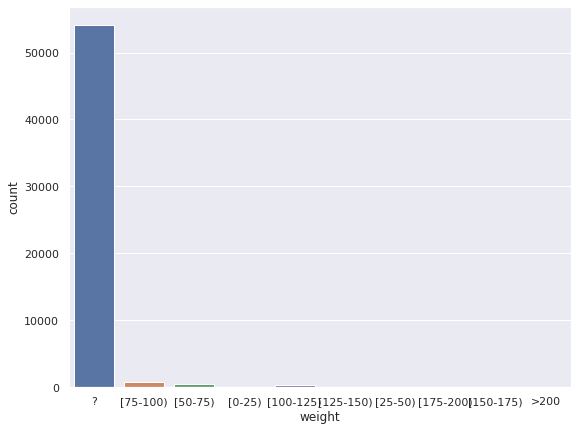

In [47]:
sns.set(rc={'figure.figsize':(9,7)})
sns.countplot(agg_drug_df['weight'])

We won't use weight as a feature as the majority of values are unknown

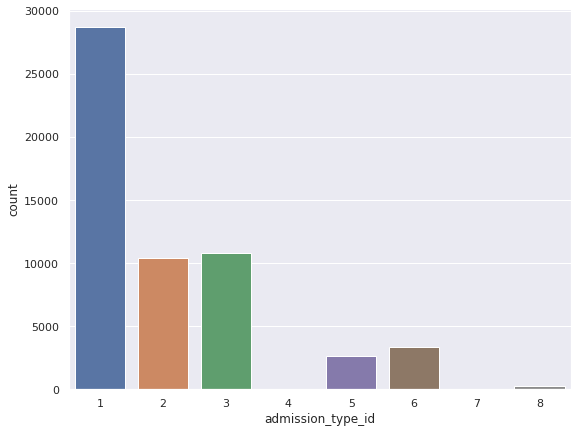

In [48]:
sns.countplot(agg_drug_df["admission_type_id"])

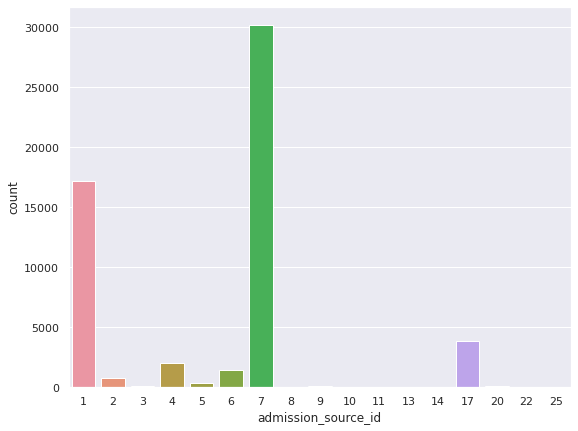

In [49]:
sns.countplot(agg_drug_df["admission_source_id"])

We won't use admission_type_id or admission_source_id as the values are heavily skewed.

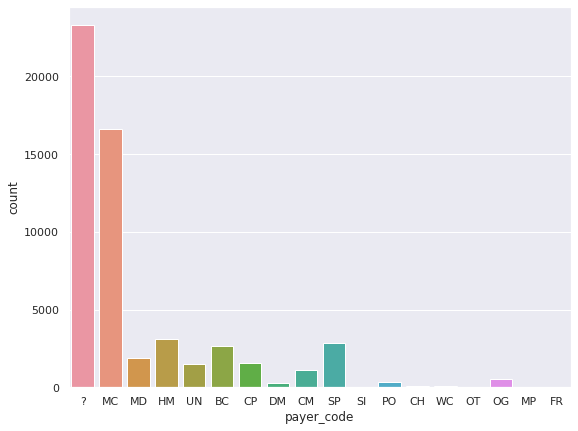

In [50]:
sns.countplot(agg_drug_df["payer_code"])

We won't use payer code as about 50% of the values are missing or unknown. This is a large number to impute

In [51]:
len(agg_drug_df[agg_drug_df["medical_specialty"] == '?'])
agg_drug_df["medical_specialty"].unique()

array(['?', 'InternalMedicine', 'Family/GeneralPractice', 'Cardiology',
       'Surgery-General', 'Orthopedics', 'Gastroenterology',
       'Surgery-Cardiovascular/Thoracic', 'Nephrology',
       'Orthopedics-Reconstructive', 'Psychiatry', 'Emergency/Trauma',
       'Surgery-Neuro', 'Obsterics&Gynecology-GynecologicOnco',
       'Pediatrics', 'ObstetricsandGynecology',
       'Pediatrics-Endocrinology', 'Hematology/Oncology',
       'Otolaryngology', 'Surgery-Colon&Rectal',
       'Pediatrics-CriticalCare', 'Endocrinology', 'Pulmonology',
       'Urology', 'Psychiatry-Child/Adolescent', 'Pediatrics-Pulmonology',
       'Anesthesiology-Pediatric', 'Radiology',
       'Pediatrics-Hematology-Oncology', 'Psychology', 'Neurology',
       'Pediatrics-Neurology', 'Surgery-Thoracic',
       'Surgery-PlasticwithinHeadandNeck', 'Gynecology',
       'Surgery-Plastic', 'Pediatrics-EmergencyMedicine',
       'PhysicalMedicineandRehabilitation', 'InfectiousDiseases',
       'Podiatry', 'Anesthesiolo

We can ignore medical_specialty too as there are a large number of ? values

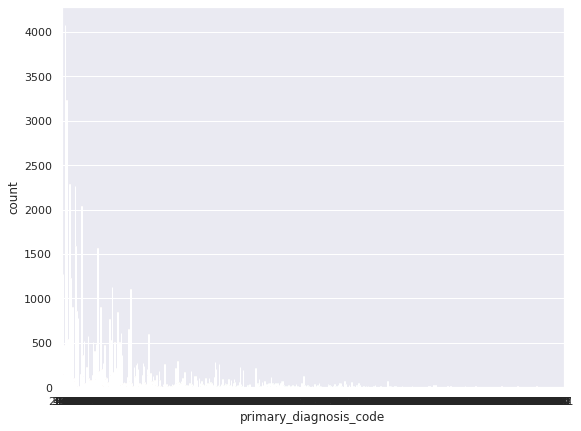

In [52]:
sns.countplot(agg_drug_df["primary_diagnosis_code"])

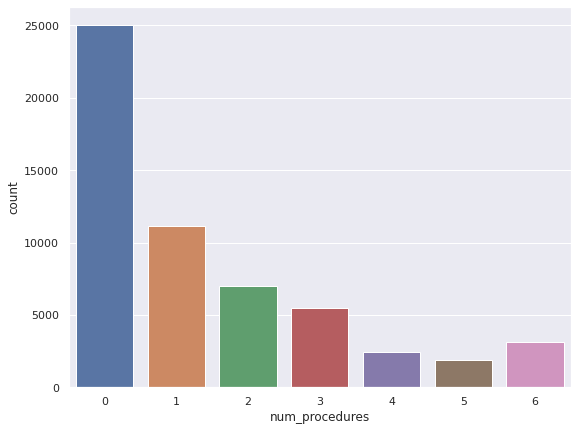

In [53]:
sns.countplot(agg_drug_df['num_procedures'])

We leave out num_procedures as close to 50% of the dataset has 0 values 

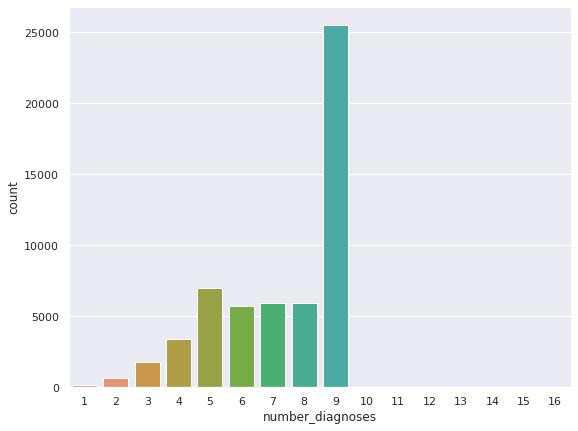

In [54]:
sns.countplot(agg_drug_df['number_diagnoses'])

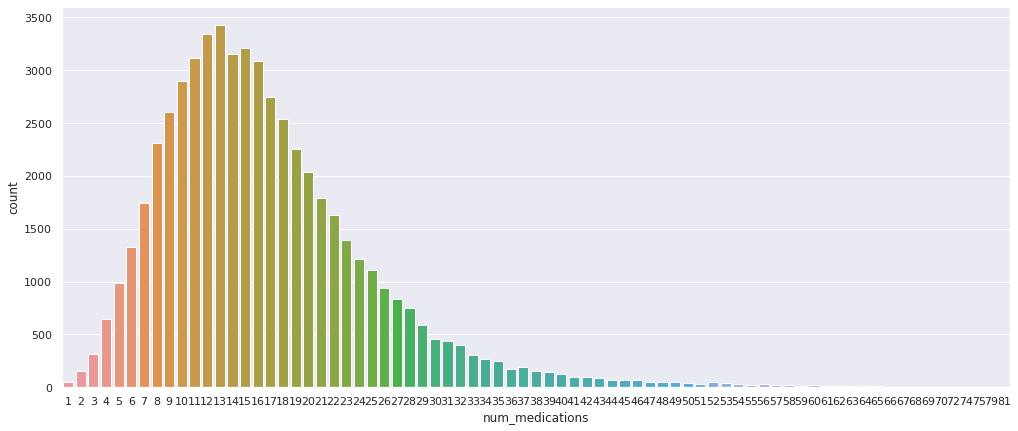

In [55]:
sns.set(rc={'figure.figsize':(17,7)})
sns.countplot(agg_drug_df['num_medications'])

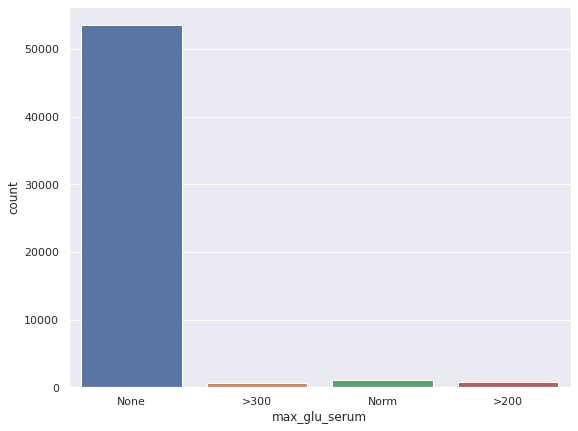

In [56]:
sns.set(rc={'figure.figsize':(9,7)})
sns.countplot(agg_drug_df['max_glu_serum'])

We leave out max_glu_serum as well as most values are "None"

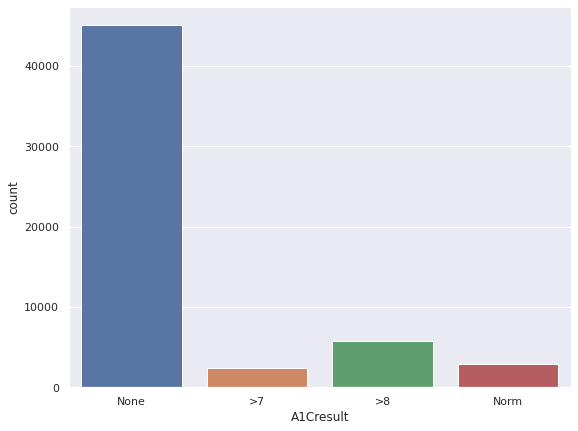

In [57]:
sns.countplot(agg_drug_df['A1Cresult'])

Even though A1Cresult is highly skewed, we will select this feature as it is most pertinent to diabetes

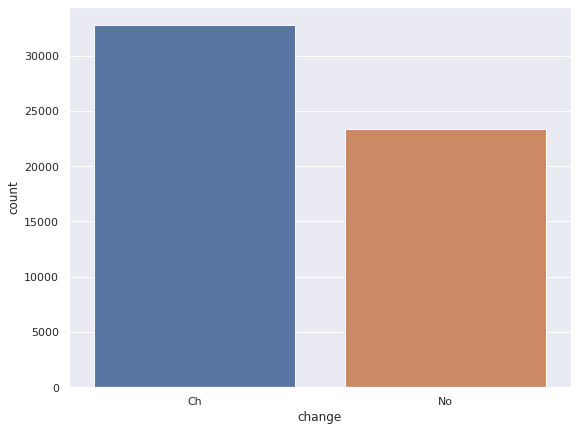

In [58]:
sns.countplot(agg_drug_df['change'])

We ignore the "change" column too as it does not add value to our analysis for hospital length stay.

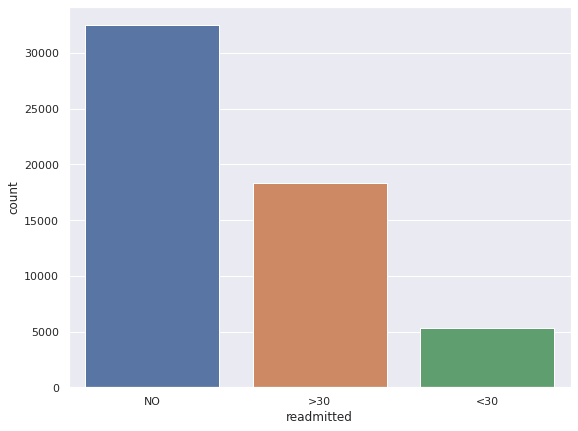

In [59]:
sns.countplot(agg_drug_df['readmitted'])

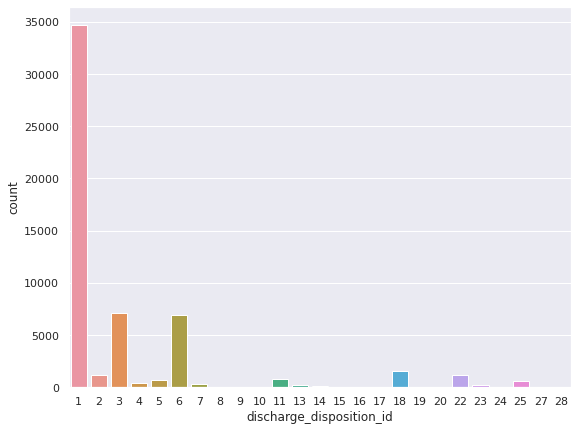

In [60]:
sns.countplot(agg_drug_df['discharge_disposition_id'])

We can't use discharge disposition id as this is a variable whose value will not be known until after discharge. 
It shouldn't therefore be used to predict time in hospital. We'll also ignore num_procedures and number_diagnoses as these have a non-normal distribution 

In [61]:
'''
Please update the list to include the features you think are appropriate for the model 
and the field that we will be using to train the model. There are three required demographic features for the model 
and I have inserted a list with them already in the categorical list. 
These will be required for later steps when analyzing data splits and model biases.
'''
required_demo_col_list = ['race', 'gender', 'age']
student_categorical_col_list = ["primary_diagnosis_code", "readmitted", "A1Cresult"] + required_demo_col_list + ndc_col_list
student_numerical_col_list = ["num_lab_procedures", "num_medications"]
PREDICTOR_FIELD = 'time_in_hospital'

In [62]:
def select_model_features(df, categorical_col_list, numerical_col_list, PREDICTOR_FIELD, grouping_key='patient_nbr'):
    selected_col_list = [grouping_key] + [PREDICTOR_FIELD] + categorical_col_list + numerical_col_list   
    return agg_drug_df[selected_col_list]


In [63]:
selected_features_df = select_model_features(agg_drug_df, student_categorical_col_list, student_numerical_col_list,
                                            PREDICTOR_FIELD)

### Preprocess Dataset - Casting and Imputing  

We will cast and impute the dataset before splitting so that we do not have to repeat these steps across the splits in the next step. For imputing, there can be deeper analysis into which features to impute and how to impute but for the sake of time, we are taking a general strategy of imputing zero for only numerical features. 

OPTIONAL: What are some potential issues with this approach? Can you recommend a better way and also implement it?

In [64]:
processed_df = preprocess_df(selected_features_df, student_categorical_col_list, 
        student_numerical_col_list, PREDICTOR_FIELD, categorical_impute_value='nan', numerical_impute_value=0)

/home/workspace/starter_code/utils.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[predictor] = df[predictor].astype(float)
/home/workspace/starter_code/utils.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = cast_df(df, c, d_type=str)
/home/workspace/starter_code/utils.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

## Split Dataset into Train, Validation, and Test Partitions

**Question 6**: In order to prepare the data for being trained and evaluated by a deep learning model, we will split the dataset into three partitions, with the validation partition used for optimizing the model hyperparameters during training. One of the key parts is that we need to be sure that the data does not accidently leak across partitions.

Please complete the function below to split the input dataset into three partitions(train, validation, test) with the following requirements.
- Approximately 60%/20%/20%  train/validation/test split
- Randomly sample different patients into each data partition
- **IMPORTANT** Make sure that a patient's data is not in more than one partition, so that we can avoid possible data leakage.
- Make sure that the total number of unique patients across the splits is equal to the total number of unique patients in the original dataset
- Total number of rows in original dataset = sum of rows across all three dataset partitions

In [65]:
from student_utils import patient_dataset_splitter
d_train, d_val, d_test = patient_dataset_splitter(processed_df, 'patient_nbr')

In [66]:
len(d_train)

33680

In [67]:
len(d_val)

11227

In [68]:
len(d_test)

11226

In [69]:
len(processed_df)

56133

In [70]:
assert len(d_train) + len(d_val) + len(d_test) == len(processed_df)
print("Test passed for number of total rows equal!")

Test passed for number of total rows equal!


In [71]:
assert (d_train['patient_nbr'].nunique() + d_val['patient_nbr'].nunique() + d_test['patient_nbr'].nunique()) == agg_drug_df['patient_nbr'].nunique()
print("Test passed for number of unique patients being equal!")

Test passed for number of unique patients being equal!


## Demographic Representation Analysis of Split

After the split, we should check to see the distribution of key features/groups and make sure that there is representative samples across the partitions. The show_group_stats_viz function in the utils.py file can be used to group and visualize different groups and dataframe partitions.

### Label Distribution Across Partitions

Below you can see the distributution of the label across your splits. Are the histogram distribution shapes similar across partitions?

time_in_hospital
1.0      7532
2.0      9473
3.0     10028
4.0      7681
5.0      5566
6.0      4122
7.0      3231
8.0      2419
9.0      1655
10.0     1292
11.0     1054
12.0      807
13.0      702
14.0      571
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


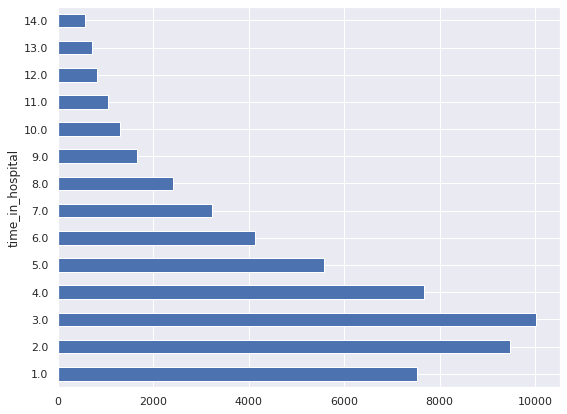

In [72]:
show_group_stats_viz(processed_df, PREDICTOR_FIELD)

time_in_hospital
1.0     4523
2.0     5622
3.0     6056
4.0     4690
5.0     3304
6.0     2509
7.0     1913
8.0     1451
9.0      978
10.0     771
11.0     653
12.0     463
13.0     397
14.0     350
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


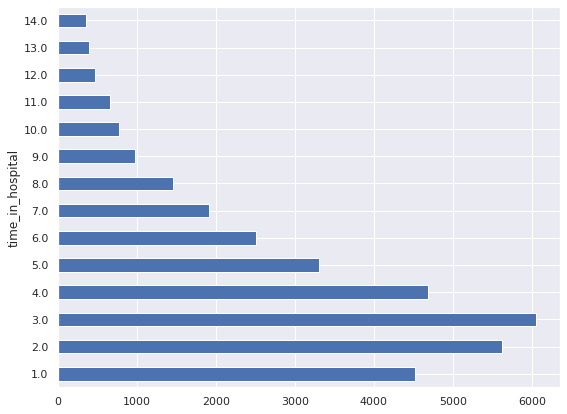

In [73]:
show_group_stats_viz(d_train, PREDICTOR_FIELD)

time_in_hospital
1.0     1503
2.0     1980
3.0     1997
4.0     1469
5.0     1142
6.0      782
7.0      660
8.0      483
9.0      312
10.0     258
11.0     209
12.0     178
13.0     140
14.0     113
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


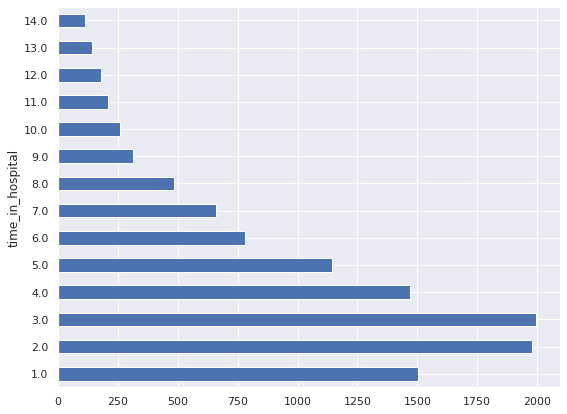

In [74]:
show_group_stats_viz(d_test, PREDICTOR_FIELD)

## Demographic Group Analysis

We should check that our partitions/splits of the dataset are similar in terms of their demographic profiles. Below you can see how we might visualize and analyze the full dataset vs. the partitions.

gender
Female             29583
Male               26548
Unknown/Invalid        2
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


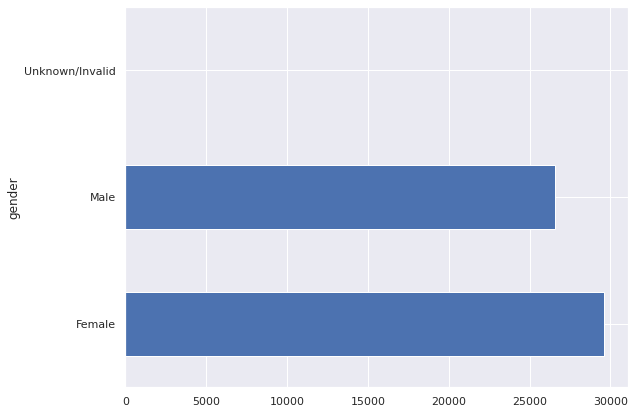

In [75]:
# Full dataset before splitting
patient_demo_features = ['race', 'gender', 'age', 'patient_nbr']
patient_group_analysis_df = processed_df[patient_demo_features].groupby('patient_nbr').head(1).reset_index(drop=True)
show_group_stats_viz(patient_group_analysis_df, 'gender')

gender
Female             17739
Male               15939
Unknown/Invalid        2
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


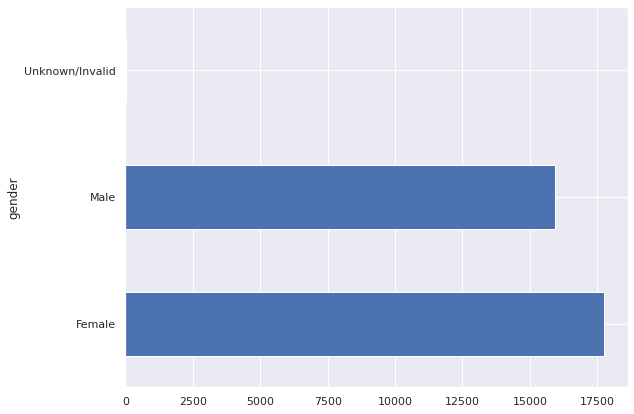

In [76]:
# Training partition
show_group_stats_viz(d_train, 'gender')

gender
Female    5965
Male      5261
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


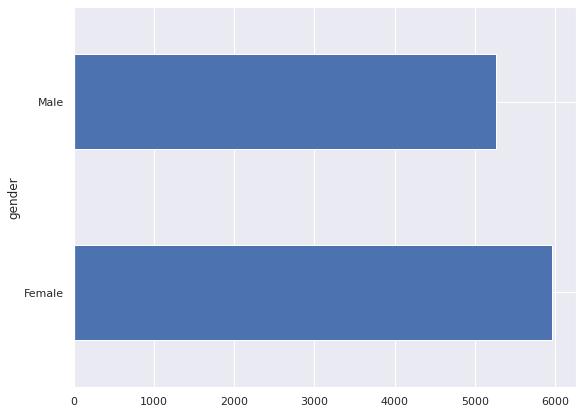

In [77]:
# Test partition
show_group_stats_viz(d_test, 'gender')

## Convert Dataset Splits to TF Dataset

We have provided you the function to convert the Pandas dataframe to TF tensors using the TF Dataset API. 
Please note that this is not a scalable method and for larger datasets, the 'make_csv_dataset' method is recommended -https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset.

In [78]:
# Convert dataset from Pandas dataframes to TF dataset 
batch_size = 128
diabetes_train_ds = df_to_dataset(d_train, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_val_ds = df_to_dataset(d_val, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_test_ds = df_to_dataset(d_test, PREDICTOR_FIELD, batch_size=batch_size)

In [79]:
# We use this sample of the dataset to show transformations later
diabetes_batch = next(iter(diabetes_train_ds))[0]
def demo(feature_column, example_batch):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))

# 4. Create Categorical Features with TF Feature Columns

## Build Vocabulary for Categorical Features

Before we can create the TF categorical features, we must first create the vocab files with the unique values for a given field that are from the **training** dataset. Below we have provided a function that you can use that only requires providing the pandas train dataset partition and the list of the categorical columns in a list format. The output variable 'vocab_file_list' will be a list of the file paths that can be used in the next step for creating the categorical features.

In [80]:
vocab_file_list = build_vocab_files(d_train, student_categorical_col_list)

## Create Categorical Features with Tensorflow Feature Column API

**Question 7**: Using the vocab file list from above that was derived fromt the features you selected earlier, please create categorical features with the Tensorflow Feature Column API, https://www.tensorflow.org/api_docs/python/tf/feature_column. Below is a function to help guide you.

In [81]:
from student_utils import create_tf_categorical_feature_cols
tf_cat_col_list = create_tf_categorical_feature_cols(student_categorical_col_list)

INFO:tensorflow:vocabulary_size = 612 in primary_diagnosis_code is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/primary_diagnosis_code_vocab.txt.
INFO:tensorflow:vocabulary_size = 4 in readmitted is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/readmitted_vocab.txt.
INFO:tensorflow:vocabulary_size = 5 in A1Cresult is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/A1Cresult_vocab.txt.
INFO:tensorflow:vocabulary_size = 7 in race is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/race_vocab.txt.
INFO:tensorflow:vocabulary_size = 4 in gender is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/gender_vocab.txt.
INFO:tensorflow:vocabulary_size = 11 in age is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/age_vocab.txt.
INFO:tensorflow:vocabulary_size = 3 in Acarbose is inferred from the number of elements in the vo

In [82]:
test_cat_var1 = tf_cat_col_list[0]
print("Example categorical field:\n{}".format(test_cat_var1))
demo(test_cat_var1, diabetes_batch)

Example categorical field:
IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='primary_diagnosis_code', vocabulary_file='./diabetes_vocab/primary_diagnosis_code_vocab.txt', vocabulary_size=612, num_oov_buckets=1, dtype=tf.string, default_value=-1))
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(128, 613), dtype=float32)


# 5. Create Numerical Features with TF Feature Columns

**Question 8**: Using the TF Feature Column API(https://www.tensorflow.org/api_docs/python/tf/feature_column/), please create normalized Tensorflow numeric features for the model. Try to use the z-score normalizer function below to help as well as the 'calculate_stats_from_train_data' function.

In [83]:
from student_utils import create_tf_numeric_feature

For simplicity the create_tf_numerical_feature_cols function below uses the same normalizer function across all features(z-score normalization) but if you have time feel free to analyze and adapt the normalizer based off the statistical distributions. You may find this as a good resource in determining which transformation fits best for the data https://developers.google.com/machine-learning/data-prep/transform/normalization.


In [84]:
def calculate_stats_from_train_data(df, col):
    mean = df[col].describe()['mean']
    std = df[col].describe()['std']
    return mean, std

def create_tf_numerical_feature_cols(numerical_col_list, train_df):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        mean, std = calculate_stats_from_train_data(train_df, c)
        tf_numeric_feature = create_tf_numeric_feature(c, mean, std)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list

In [85]:
tf_cont_col_list = create_tf_numerical_feature_cols(student_numerical_col_list, d_train)

In [86]:
test_cont_var1 = tf_cont_col_list[0]
print("Example continuous field:\n{}\n".format(test_cont_var1))
demo(test_cont_var1, diabetes_batch)

Example continuous field:
NumericColumn(key='num_lab_procedures', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=functools.partial(<function normalize_numeric_with_zscore at 0x7f7660b140e0>, mean=43.59005344418052, std=20.081656450517304))

tf.Tensor(
[[ 0.8 ]
 [ 1.1 ]
 [-0.35]
 [-0.45]
 [ 0.6 ]
 [ 0.6 ]
 [ 0.15]
 [ 1.  ]
 [-0.6 ]
 [ 1.45]
 [ 0.8 ]
 [-0.25]
 [ 0.35]
 [ 1.3 ]
 [-1.6 ]
 [-0.3 ]
 [-0.3 ]
 [-0.5 ]
 [ 0.35]
 [ 1.45]
 [ 0.4 ]
 [ 0.15]
 [ 0.95]
 [-2.1 ]
 [-0.7 ]
 [-0.15]
 [-2.1 ]
 [-1.2 ]
 [ 0.6 ]
 [ 0.9 ]
 [-1.7 ]
 [ 0.8 ]
 [ 0.35]
 [ 0.45]
 [ 0.8 ]
 [-1.75]
 [-0.7 ]
 [-1.55]
 [ 0.85]
 [ 0.6 ]
 [ 1.1 ]
 [-0.35]
 [-0.3 ]
 [ 0.05]
 [-1.3 ]
 [ 1.2 ]
 [ 0.4 ]
 [ 0.45]
 [-2.1 ]
 [ 0.35]
 [ 0.55]
 [-0.55]
 [-2.1 ]
 [ 0.  ]
 [ 0.25]
 [-0.5 ]
 [ 0.  ]
 [ 1.1 ]
 [-1.5 ]
 [ 1.1 ]
 [-0.45]
 [ 0.25]
 [-2.05]
 [ 0.05]
 [-0.2 ]
 [ 1.5 ]
 [-0.25]
 [-0.2 ]
 [-0.35]
 [ 0.6 ]
 [ 0.45]
 [ 1.15]
 [-0.7 ]
 [ 0.05]
 [ 1.4 ]
 [ 0.3 ]
 [-2.1 ]
 [-0.45]
 [ 1.05]
 [ 0.25]
 [ 1.3 ]
 [

# 6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers

## Use DenseFeatures to combine features for model

Now that we have prepared categorical and numerical features using Tensorflow's Feature Column API, we can combine them into a dense vector representation for the model. Below we will create this new input layer, which we will call 'claim_feature_layer'.

In [87]:
claim_feature_columns = tf_cat_col_list + tf_cont_col_list
claim_feature_layer = tf.keras.layers.DenseFeatures(claim_feature_columns)

## Build Sequential API Model from DenseFeatures and TF Probability Layers

Below we have provided some boilerplate code for building a model that connects the Sequential API, DenseFeatures, and Tensorflow Probability layers into a deep learning model. There are many opportunities to further optimize and explore different architectures through benchmarking and testing approaches in various research papers, loss and evaluation metrics, learning curves, hyperparameter tuning, TF probability layers, etc. Feel free to modify and explore as you wish.

**OPTIONAL**: Come up with a more optimal neural network architecture and hyperparameters. Share the process in discovering the architecture and hyperparameters.

In [88]:
def build_sequential_model(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(75, activation='relu'),
        tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable),
        tfp.layers.DistributionLambda(
            lambda t:tfp.distributions.Normal(loc=t[..., :1],
                                             scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])
                                             )
        ),
    ])
    return model

def build_diabetes_model(train_ds, val_ds,  feature_layer,  epochs=5, loss_metric='mse'):
    model = build_sequential_model(feature_layer)
    model.compile(optimizer='rmsprop', loss=loss_metric, metrics=[loss_metric])
    early_stop = tf.keras.callbacks.EarlyStopping(monitor=loss_metric, patience=3)     
    history = model.fit(train_ds, validation_data=val_ds,
                        callbacks=[early_stop],
                        epochs=epochs)
    return model, history 

In [89]:
diabetes_model, history = build_diabetes_model(diabetes_train_ds, diabetes_val_ds,  claim_feature_layer,  epochs=10)

Train for 264 steps, validate for 88 steps
Epoch 1/10
264/264 [==============================] - 9s 33ms/step - loss: 26.1136 - mse: 25.9716 - val_loss: 24.0562 - val_mse: 23.8110
Epoch 2/10
264/264 [==============================] - 5s 18ms/step - loss: 20.3381 - mse: 19.7360 - val_loss: 18.5588 - val_mse: 18.2002
Epoch 3/10
264/264 [==============================] - 5s 18ms/step - loss: 14.9403 - mse: 14.1240 - val_loss: 14.7665 - val_mse: 14.0973
Epoch 4/10
264/264 [==============================] - 4s 17ms/step - loss: 13.7752 - mse: 13.0173 - val_loss: 11.8403 - val_mse: 10.8537
Epoch 5/10
264/264 [==============================] - 5s 17ms/step - loss: 12.5592 - mse: 11.6306 - val_loss: 12.3879 - val_mse: 11.4470
Epoch 6/10
264/264 [==============================] - 5s 17ms/step - loss: 11.0150 - mse: 10.0896 - val_loss: 10.9323 - val_mse: 10.1586
Epoch 7/10
264/264 [==============================] - 5s 17ms/step - loss: 10.7008 - mse: 9.8612 - val_loss: 9.7014 - val_mse: 8.9490
E

## Show Model Uncertainty Range with TF Probability

**Question 9**: Now that we have trained a model with TF Probability layers, we can extract the mean and standard deviation for each prediction. Please fill in the answer for the m and s variables below. The code for getting the predictions is provided for you below.

In [90]:
feature_list = student_categorical_col_list + student_numerical_col_list
diabetes_x_tst = dict(d_test[feature_list])
diabetes_yhat = diabetes_model(diabetes_x_tst)
preds = diabetes_model.predict(diabetes_test_ds)

In [91]:
from student_utils import get_mean_std_from_preds
m, s = get_mean_std_from_preds(diabetes_yhat)

## Show Prediction Output 

In [92]:
prob_outputs = {
    "pred": preds.flatten(),
    "actual_value": d_test['time_in_hospital'].values,
    "pred_mean": m.numpy().flatten(),
    "pred_std": s.numpy().flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)

In [93]:
prob_output_df.head()

,pred,actual_value,pred_mean,pred_std
0,7.125563,3.0,4.558374,0.694117
1,5.751783,2.0,2.689210,0.693643
2,1.672622,1.0,4.193475,0.694429
3,5.160763,2.0,5.980470,0.694200
4,5.865129,2.0,5.920136,0.694126


## Convert Regression Output to Classification Output for Patient Selection

**Question 10**: Given the output predictions, convert it to a binary label for whether the patient meets the time criteria or does not (HINT: use the mean prediction numpy array). The expected output is a numpy array with a 1 or 0 based off if the prediction meets or doesnt meet the criteria.

In [94]:
from student_utils import get_student_binary_prediction
student_binary_prediction = get_student_binary_prediction(prob_output_df, 'pred_mean')

### Add Binary Prediction to Test Dataframe

Using the student_binary_prediction output that is a numpy array with binary labels, we can use this to add to a dataframe to better visualize and also to prepare the data for the Aequitas toolkit. The Aequitas toolkit requires that the predictions be mapped to a binary label for the predictions (called 'score' field) and the actual value (called 'label_value').

In [95]:
def add_pred_to_test(test_df, pred_np, demo_col_list):
    for c in demo_col_list:
        test_df[c] = test_df[c].astype(str)
    test_df['score'] = pred_np
    test_df['label_value'] = test_df['time_in_hospital'].apply(lambda x: 1 if x >=5 else 0)
    return test_df

pred_test_df = add_pred_to_test(d_test, student_binary_prediction, ['race', 'gender'])

In [96]:
pred_test_df[['patient_nbr', 'gender', 'race', 'time_in_hospital', 'score', 'label_value']].head()

,patient_nbr,gender,race,time_in_hospital,score,label_value
0,66597354,Female,Caucasian,3.0,0,0
1,43715259,Female,Caucasian,2.0,0,0
2,25301016,Female,AfricanAmerican,1.0,0,0
3,100351521,Female,Caucasian,2.0,1,0
4,112880682,Male,Caucasian,2.0,1,0


## Model Evaluation Metrics 

**Question 11**: Now it is time to use the newly created binary labels in the 'pred_test_df' dataframe to evaluate the model with some common classification metrics. Please create a report summary of the performance of the model and be sure to give the ROC AUC, F1 score(weighted), class precision and recall scores. 

For the report please be sure to include the following three parts:
- With a non-technical audience in mind, explain the precision-recall tradeoff in regard to how you have optimized your model.

- What are some areas of improvement for future iterations?

Accuracy:  0.6117049706039551
Classification report: 
               precision    recall  f1-score   support

           0       0.91      0.41      0.57      6949
           1       0.49      0.93      0.65      4277

    accuracy                           0.61     11226
   macro avg       0.70      0.67      0.61     11226
weighted avg       0.75      0.61      0.60     11226

ROC AUC:  0.6736814056572296
F1 score(weighted):  0.598441071060494


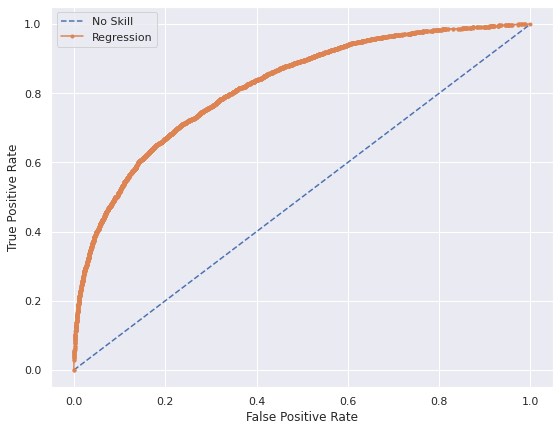

In [99]:
# AUC, F1, precision and recall
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_curve, roc_auc_score
y_true = pred_test_df['label_value'].values 
y_pred = pred_test_df['score'].values
pred_prob = prob_output_df['pred_mean'].values

print("Accuracy: ", accuracy_score(y_true, y_pred))

print("Classification report: \n", classification_report(y_true, y_pred))

print("ROC AUC: ", roc_auc_score(y_true, y_pred))

print("F1 score(weighted): ", f1_score(y_true, y_pred, average='weighted'))

ns_probs = [0 for _ in range(len(pred_test_df))]

ns_fpr, ns_tpr, _ = roc_curve(y_true, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_true, pred_prob)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Regression')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

#### Summary:

The accuracy of the model is approximately 71%. The weighted average of precision is 0.76 while the weighted average of recall is 0.71. The weighted F1 score is around 0.66 and ROC AUC is 0.63.

A good model exhibits high precision and high recall. The F1 score is the harmonic mean of the two, and a high value for the F1 score implies that on the balance, the precision and recall are both high and one does not suffer at the expense of the other. In this hospital stay problem, precision seems to be a metric that should be weighted higher than recall. We want low false positives, as we want to correctly identify and administer the diabetes drug to only those patients that will indeed be in hospital for the length of stay needed to monitor the usage of the drug. A high false negative has a less significant impact here. It is less critical if we did not administer the drug to every single patient that was forecast to have a long hospital stay since our model incorrectly predicted that they would have a short hospital stay. 

In a binary classification scenario, which we have used here by converting the regression output to a binary score, a high precision answers the following question: Out of the patient records that were identified by the model as being true cases, i.e. requiring a long hospital stay, how many of these truly required long stay per their actual labelling. A high precision implies low false positives. Recall on the other hand, answers the following question: Out of all the patient records in the dataset, how many of these were correctly identified by the model as being true cases, i.e. requiring a long hospital stay. High recall implies low false negatives.

An optimal model must balance precision vs. recall. If we adjust the cut-off threshold (number of days in this case) to label long stay (+ve) vs. short stay (-ve) cases, a lower threshold will result in high false positives but low false negatives. A higher threshold will do exactly the opposite. Here, we have chosen the number of threshold days = 5.

A number of things can be put in place to further improve the model:

* Introduce regularization to avoid overfitting
* Apply learning rate decay and use validation dataset to tune the learning rate
* Run for more epochs - we can see at the end of epoch 10 that the MSE is continuing to decrease
* Try different neural net architectures
* Try different optimizers 


# 7. Evaluating Potential Model Biases with Aequitas Toolkit

## Prepare Data For Aequitas Bias Toolkit 

Using the gender and race fields, we will prepare the data for the Aequitas Toolkit.

In [100]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

ae_subset_df = pred_test_df[['race', 'gender', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()


/opt/conda/lib/python3.7/site-packages/aequitas/group.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = df['score'].astype(float)


model_id, score_thresholds 1 {'rank_abs': [8072]}


## Reference Group Selection

Below we have chosen the reference group for our analysis but feel free to select another one.

In [101]:
# test reference group with Caucasian Male
bdf = b.get_disparity_predefined_groups(clean_xtab, 
                    original_df=ae_df, 
                    ref_groups_dict={'race':'Caucasian', 'gender':'Male'
                                     }, 
                    alpha=0.05, 
                    check_significance=False)


f = Fairness()
fdf = f.get_group_value_fairness(bdf)

get_disparity_predefined_group()


/opt/conda/lib/python3.7/site-packages/aequitas/bias.py:368: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  df = df.replace(pd.np.inf, fill_divbyzero)
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:32: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.fair_eval = lambda tau: lambda x: pd.np.nan if pd.np.isnan(x) else \
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:45: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.high_level_pair_eval = lambda col1, col2: lambda x: pd.np.nan if (pd.np.isnan(x[col1]) and pd.np.isnan(x[col2])) \


## Race and Gender Bias Analysis for Patient Selection

**Question 12**: For the gender and race fields, please plot two metrics that are important for patient selection below and state whether there is a significant bias in your model across any of the groups along with justification for your statement.

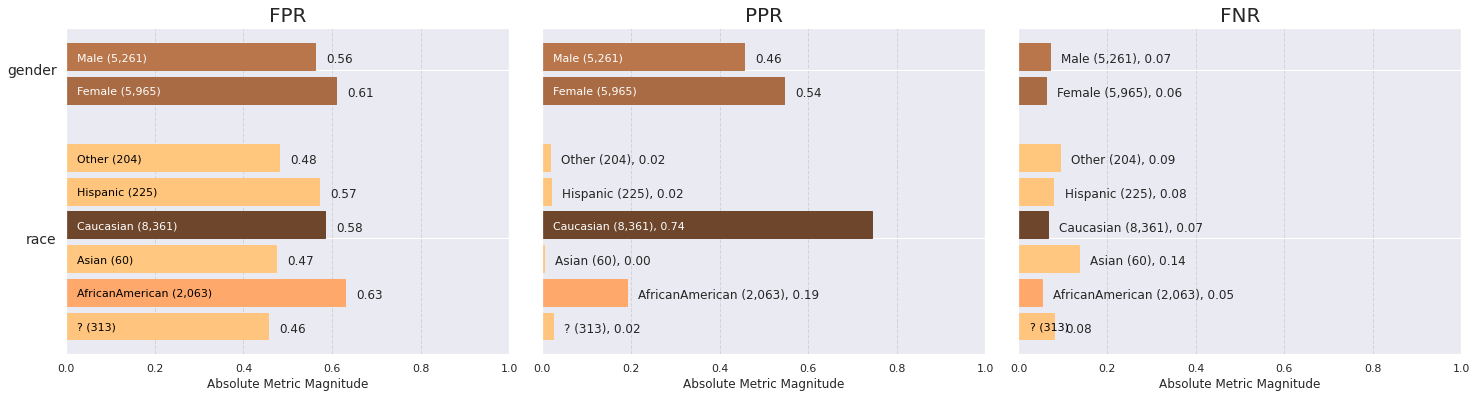

In [102]:
# Plot two metrics

# We plot the false positive rate, predicted positive ratio and false negative ratio disparity 
p = aqp.plot_group_metric_all(xtab, metrics=['fpr', 'ppr', 'fnr'], ncols=3)

# Is there significant bias in your model for either race or gender?

The disparity across gender for all 3 metrics is insignificant. But there is exists a noticeable race disparity.
Asians have a lower FPR while Caucasian and African American have higher FPR. 
The PPR for Caucasians is disproportionately high, followed by African American patients, relative to other races. This means that our model is correctly predicting long hospital stays for most Caucasian patients identified as having long hospital stays, but not very well at all for patients from other races.
There is a higher FNR for Asian patients than for other races. This implies that where Asian patients are predicted to leave hospital early, they are actually staying in longer than 5 days. 

## Fairness Analysis Example - Relative to a Reference Group 

**Question 13**: Earlier we defined our reference group and then calculated disparity metrics relative to this grouping. Please provide a visualization of the fairness evaluation for this reference group and analyze whether there is disparity.

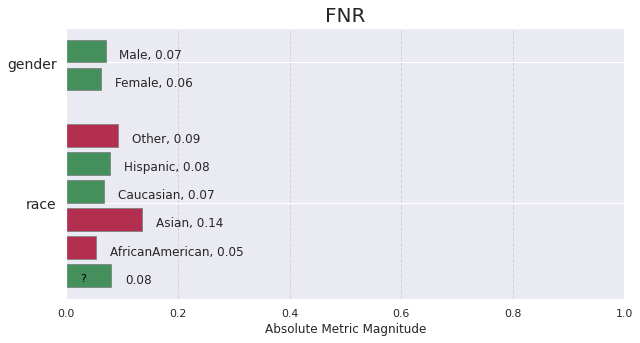

In [104]:
# Reference group fairness plot
fpr_fairness = aqp.plot_fairness_group(fdf, group_metric='fnr', title=True)

We can see from the above that relative to our reference group of Caucasian males, Asians and African American and Other race patients are likely to be unfairly served by our model with higher false negative rates respectively. They are actually staying in hospital for longer than we predict, but with the model classifying them as negative cases, they are unlikely to be administered the new diabetes drug.

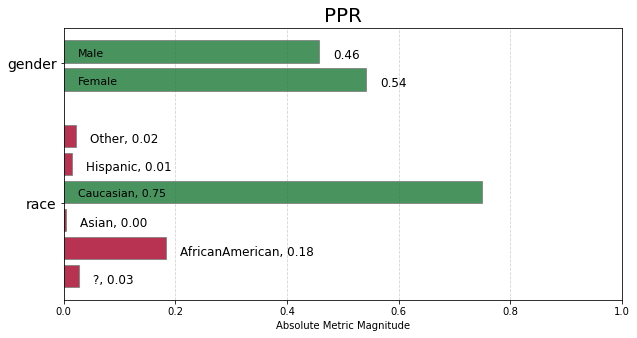

In [47]:
fpr_fairness = aqp.plot_fairness_group(fdf, group_metric='ppr', title=True)

Again, we see from the above that relative to our reference group of Caucasian males, every other race patient is likely to be unfairly served by our model with significantly lower positive predicted ratio.